# Convolution Plots

In [10]:
from os.path import expanduser, join
from pathlib import Path
import sys

from cycler import cycler
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import xarray as xr

user_home_dir = expanduser('~')
sys.path.insert(0, join(user_home_dir, "emu-utilities"))
from emu_utilities import convolution

## Load Datasets

In [11]:
NOTEBOOK_DIR = Path().resolve()
FIGURES_DIR = Path(NOTEBOOK_DIR / "../../figures").resolve()
DATA_DIR_ECCO = Path("/efs_ecco/ascherer/datasets")
DATA_DIR_A = Path("/efs_ecco/ascherer")
DATA_DIR_S = Path("/efs_ecco/sjarugul")
TS_DAILY_PATH = DATA_DIR_ECCO / "v4r5/surface_sal_temp_fw_daily_latlon_10N-20S_90E-120E.nc"
TS_MONTHLY_PATH = DATA_DIR_ECCO / "v4r4/surface_sal_temp_fw_monthly_latlon_10N-20S_90E-120E.nc"
SST_ADJ_T_94_PATH = DATA_DIR_A / "conv/emu_conv_30_33_3_mask3d.105.0_115.0_-12.0_-8.0_10.0_0.0_1_52"
SST_ADJ_T_10_PATH = DATA_DIR_A / "conv/emu_conv_222_225_3_mask3d.105.0_115.0_-12.0_-8.0_10.0_0.0_1_52"
SSS_ADJ_S_94_PATH = DATA_DIR_S / "EMU_SSS_Conv/emu_conv_30_33_4_mask3d.105.0_115.0_-12.0_-8.0_10.0_0.0_1_52"
SSS_ADJ_S_10_PATH = DATA_DIR_S / "EMU_SSS_Conv/emu_conv_222_225_4_mask3d.105.0_115.0_-12.0_-8.0_10.0_0.0_1_52"

In [12]:
ds_conv_t_94 = convolution.load_1d_conv_gradient(SST_ADJ_T_94_PATH)
ds_conv_t_94 = ds_conv_t_94.resample(time="1ME").mean()
ds_conv_t_94 = ds_conv_t_94 - ds_conv_t_94.mean(dim="time")
ds_conv_t_94["month_no"] = (["time"], np.arange(ds_conv_t_94["time"].size))

ds_conv_t_10 = convolution.load_1d_conv_gradient(SST_ADJ_T_10_PATH)
ds_conv_t_10 = ds_conv_t_10.resample(time="1ME").mean()
ds_conv_t_10 = ds_conv_t_10 - ds_conv_t_10.mean(dim="time")
ds_conv_t_10["month_no"] = (["time"], np.arange(ds_conv_t_10["time"].size))

ds_conv_s_94 = convolution.load_1d_conv_gradient(SSS_ADJ_S_94_PATH)
ds_conv_s_94 = ds_conv_s_94.resample(time="1ME").mean()
ds_conv_s_94 = ds_conv_s_94 - ds_conv_s_94.mean(dim="time")
ds_conv_s_94["month_no"] = (["time"], np.arange(ds_conv_t_94["time"].size))

ds_conv_s_10 = convolution.load_1d_conv_gradient(SSS_ADJ_S_10_PATH)
ds_conv_s_10 = ds_conv_s_10.resample(time="1ME").mean()
ds_conv_s_10 = ds_conv_s_10 - ds_conv_s_10.mean(dim="time")
ds_conv_s_10["month_no"] = (["time"], np.arange(ds_conv_t_10["time"].size))

ds_monthly = xr.open_dataset(TS_MONTHLY_PATH)
ds_monthly = ds_monthly.resample(time="1ME").mean()
ds_monthly = ds_monthly - ds_monthly.mean(dim="time")
ds_monthly["month_no"] = (["time"], np.arange(ds_monthly["time"].size))
ds_monthly = ds_monthly.sel(lat=slice(-12, -8), lon=slice(105, 115)).mean(dim=["lat", "lon"])

## Calculate Climatologies and Anomalies

In [13]:
def calc_climatology(t, y, harmonics: int, f: float = 1/365.2422, fit_axis: int = -1, diag: bool = False):
    if y.ndim > 1:
        niter = 1
        flat_shape = (y.shape[-1]) 
        y = np.moveaxis(y, fit_axis, -1)
        niter = y.shape[:-1]
        niter = int(np.sum(niter))
        flat_shape = (niter, y.shape[-1])
        fit = np.full(flat_shape, np.nan)
        y_flat = y.reshape(flat_shape)
        for i in range(niter):
            exog = np.full((harmonics * 2, len(t)), np.nan)
            for j in range(harmonics * 2):
                if j % 2 == 0:
                    exog[j] = np.sin((j // 2 + 1) * 2 * np.pi * f * t)
                else:
                    exog[j] = np.cos((j // 2 + 1) * 2 * np.pi * f * t)
            exog = exog.T
            exog = sm.add_constant(exog)
            endog = y_flat[i]
            # print(exog, endog)
            mod = sm.OLS(endog, exog)
            res = mod.fit()
            fit[i] = res.params@exog.T
            if diag:
                print(res.summary())
        fit = np.moveaxis(fit.reshape(y.shape), -1, fit_axis)
    else:
        exog = np.full((harmonics * 2, len(t)), np.nan)
        for j in range(harmonics * 2):
            if j % 2 == 0:
                exog[j] = np.sin((j // 2 + 1) * 2 * np.pi * f * t)
            else:
                exog[j] = np.cos((j // 2 + 1) * 2 * np.pi * f * t)
        exog = exog.T
        exog = sm.add_constant(exog)
        endog = y
        # print(exog, endog)
        mod = sm.OLS(endog, exog)
        res = mod.fit()
        fit = res.params@exog.T
        if diag:
            print(res.summary())
    return fit


def calc_conv_anomaly(ds):
    ds_anom = ds.copy()
    for data_var in ds_anom.keys():
        if data_var == "month_no":
            continue
        monthly_mean = ds_anom[data_var].groupby("time.month").mean()
        clima = xr.DataArray(
            calc_climatology(monthly_mean["month"].values, monthly_mean.values, 3, f=1/12, fit_axis=0),
            coords={
                "month": monthly_mean["month"],
                "lag": monthly_mean["lag"],
            }
        )
        
        ds_anom[data_var] = ds[data_var].groupby("time.month") - clima
    ds_anom = ds_anom.drop_vars("month_no")
    return ds_anom


def calc_v4_anom(ds):
    ds_anom = ds.copy()
    for data_var in ds_anom.keys():
        if data_var == "month_no":
            continue
        monthly_mean = ds_anom[data_var].groupby("time.month").mean()
        clima = xr.DataArray(
            calc_climatology(monthly_mean["month"].values, monthly_mean.values, 3, f=1/12, fit_axis=0),
            coords={
                "month": monthly_mean["month"],
            }
        )
        
        ds_anom[data_var] = ds[data_var].groupby("time.month") - clima
    return ds_anom
    

In [14]:
ds_conv_t_94_anom = calc_conv_anomaly(ds_conv_t_94)
ds_conv_t_10_anom = calc_conv_anomaly(ds_conv_t_10)
ds_conv_s_94_anom = calc_conv_anomaly(ds_conv_s_94)
ds_conv_s_10_anom = calc_conv_anomaly(ds_conv_s_10)
ds_monthly_anom = calc_v4_anom(ds_monthly)

## Make Plots

In [19]:
def plot_v4_time_series(da_list: list[xr.DataArray], labels: list[str], y_label: str, name: str, custom_cycler = None):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    plt.subplots_adjust(hspace=0.5) 
    ax1.set_prop_cycle(custom_cycler)
    ax2.set_prop_cycle(custom_cycler)
    for da, lab in zip(da_list, labels):
        ax1.plot(da["time"], da, label=lab)
        ax2.plot(da["time"], da, label=lab)
    ax1.set_xlim(np.datetime64("1992-01-01"), np.datetime64("2005-01-01"))
    ax2.set_xlim(np.datetime64("2005-01-01"), np.datetime64("2018-01-01"))
    for ax in (ax1, ax2):
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        ax.axhline(0, lw=1, c="gray")
        ax.grid(c="gray", alpha=0.5, ls="--")
        ax.legend(ncols=3, loc="upper left")
    ylim = ax1.get_ylim()
    ax1.fill_betweenx(y=ylim, x1=np.datetime64("1994-06-01"), x2=np.datetime64("1994-10-01"), color="gray", alpha=0.5)
    ax2.fill_betweenx(y=ylim, x1=np.datetime64("2010-06-01"), x2=np.datetime64("2010-10-01"), color="gray", alpha=0.5)
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    fig.supylabel(y_label)
    plt.savefig(FIGURES_DIR / name, bbox_inches="tight", dpi=600)

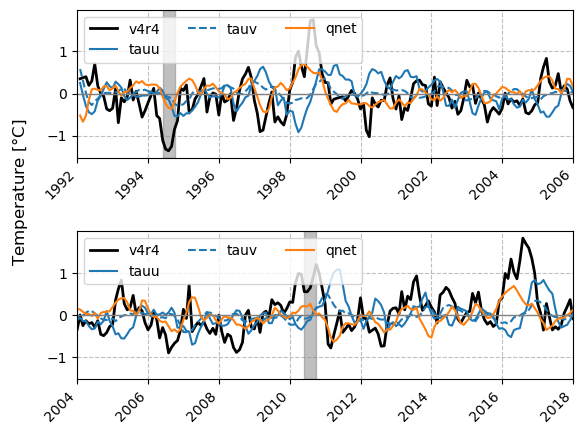

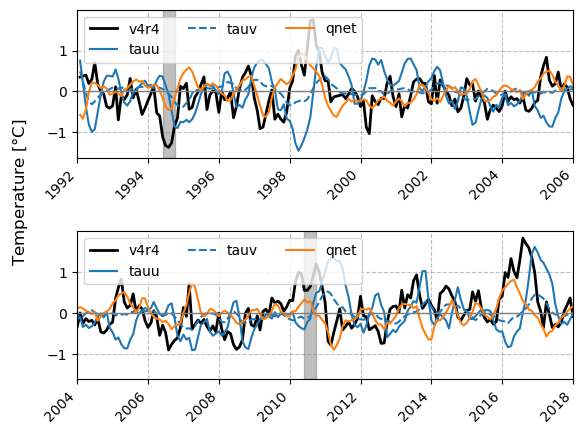

In [20]:
plot_v4_time_series(
    da_list=[
        ds_monthly_anom["sea_surface_temperature"],
        ds_conv_t_94_anom["tauu"].sel(lag=24),
        ds_conv_t_94_anom["tauv"].sel(lag=24),
        ds_conv_t_94_anom["qnet"].sel(lag=24),
    ],
    labels=[
        "v4r4",
        "tauu",
        "tauv",
        "qnet",
    ],
    y_label="Temperature [$\\mathsf{\\degree C}$]",
    name="sst_conv_reconstructed_1994_objf.png",
    custom_cycler=(
        cycler(color=['k', '#1f77b4', '#1f77b4', '#ff7f0e'])
        + cycler(ls=['-', '-', '--', '-'])
        + cycler(lw=[2, 1.5, 1.5, 1.5])
    )
)

plot_v4_time_series(
    da_list=[
        ds_monthly_anom["sea_surface_temperature"],
        ds_conv_t_10_anom["tauu"].sel(lag=24),
        ds_conv_t_10_anom["tauv"].sel(lag=24),
        ds_conv_t_10_anom["qnet"].sel(lag=24),
    ],
    labels=[
        "v4r4",
        "tauu",
        "tauv",
        "qnet",
    ],
    y_label="Temperature [$\\mathsf{\\degree C}$]",
    name="sst_conv_reconstructed_2010_objf.png",
    custom_cycler=(
        cycler(color=['k', '#1f77b4', '#1f77b4', '#ff7f0e'])
        + cycler(ls=['-', '-', '--', '-'])
        + cycler(lw=[2, 1.5, 1.5, 1.5])
    )
)
        

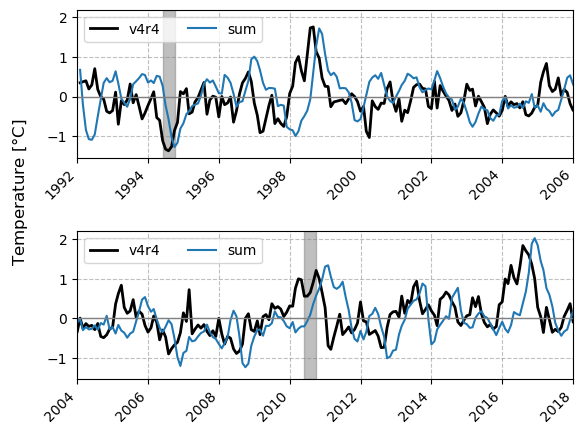

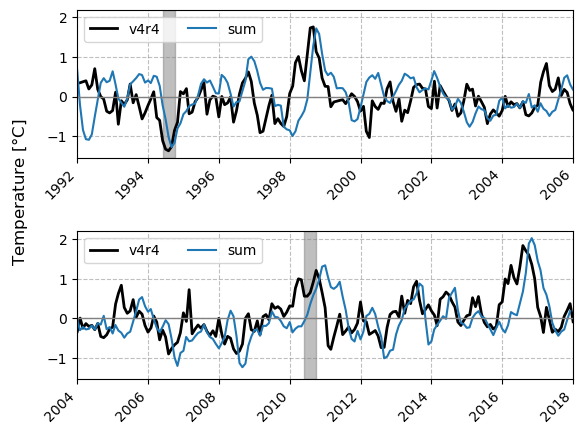

In [23]:
plot_v4_time_series(
    da_list=[
        ds_monthly_anom["sea_surface_temperature"],
        ds_conv_t_10_anom["tauu"].sel(lag=24) + ds_conv_t_10_anom["tauv"].sel(lag=24) + ds_conv_t_10_anom["qnet"].sel(lag=24),
    ],
    labels=[
        "v4r4",
        "sum",
    ],
    y_label="Temperature [$\\mathsf{\\degree C}$]",
    name="sst_conv_reconstructed_1994_objf_sum.png",
    custom_cycler=(
        cycler(color=['k', '#1f77b4', '#1f77b4', '#ff7f0e'])
        + cycler(ls=['-', '-', '--', '-'])
        + cycler(lw=[2, 1.5, 1.5, 1.5])
    )
)

ds_conv_t_10_anom_offset = ds_conv_t_10_anom.copy()
ds_conv_t_10_anom_offset["time"] = ds_conv_t_10_anom_offset["time"] - np.timedelta64(1, "M").astype("timedelta64[ns]")

plot_v4_time_series(
    da_list=[
        ds_monthly_anom["sea_surface_temperature"],
        ds_conv_t_10_anom_offset["tauu"].sel(lag=24) + ds_conv_t_10_anom_offset["tauv"].sel(lag=24) + ds_conv_t_10_anom_offset["qnet"].sel(lag=24),
    ],
    labels=[
        "v4r4",
        "sum",
    ],
    y_label="Temperature [$\\mathsf{\\degree C}$]",
    name="sst_conv_reconstructed_2010_objf_sum_offset_6mos.png",
    custom_cycler=(
        cycler(color=['k', '#1f77b4', '#1f77b4', '#ff7f0e'])
        + cycler(ls=['-', '-', '--', '-'])
        + cycler(lw=[2, 1.5, 1.5, 1.5])
    )
)

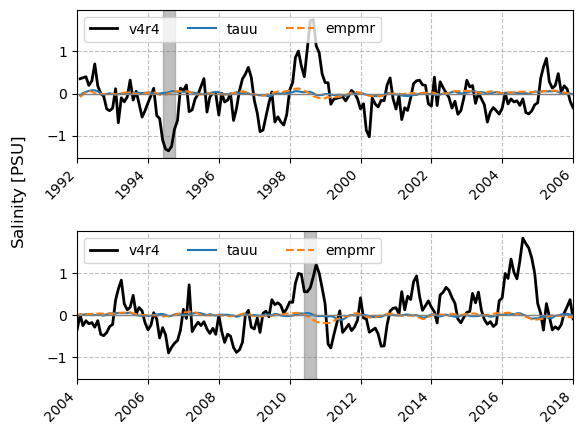

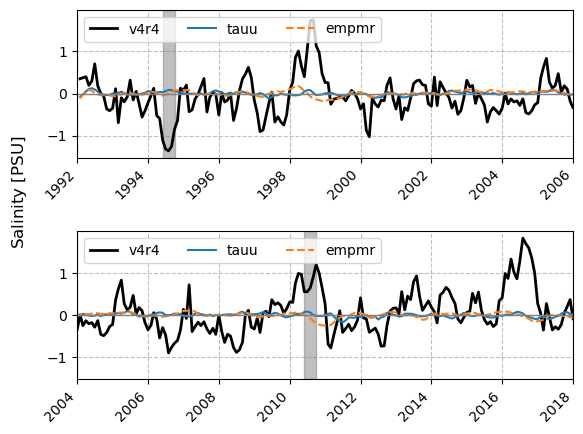

In [301]:
plot_v4_time_series(
    da_list=[
        ds_monthly_anom["sea_surface_temperature"],
        ds_conv_s_94_anom["tauu"].sel(lag=24),
        ds_conv_s_94_anom["empmr"].sel(lag=24),
    ],
    labels=[
        "v4r4",
        "tauu",
        "empmr",
    ],
    y_label="Salinity [$\\mathsf{PSU}$]",
    name="sss_conv_reconstructed_1994_objf.png",
    custom_cycler=(
        cycler(color=['k', '#1f77b4', '#ff7f0e',])
        + cycler(ls=['-', '-', '--'])
        + cycler(lw=[2, 1.5, 1.5])
    )
)

plot_v4_time_series(
    da_list=[
        ds_monthly_anom["sea_surface_temperature"],
        ds_conv_s_10_anom["tauu"].sel(lag=24),
        ds_conv_s_10_anom["empmr"].sel(lag=24),
    ],
    labels=[
        "v4r4",
        "tauu",
        "empmr",
    ],
    y_label="Salinity [$\\mathsf{PSU}$]",
    name="sss_conv_reconstructed_2010_objf.png",
    custom_cycler=(
        cycler(color=['k', '#1f77b4', '#ff7f0e',])
        + cycler(ls=['-', '-', '--'])
        + cycler(lw=[2, 1.5, 1.5])
    )
)
        

## Plot Explained Variance

In [325]:
def plot_ev_ctrl(ds_t_ev_ctrl_94, ds_t_ev_ctrl_10, ds_s_ev_ctrl_94, ds_s_ev_ctrl_10, name):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(ds_t_ev_ctrl_94["control"], ds_t_ev_ctrl_94, label="SST 1994", c="#1f77b4")
    ax.scatter(ds_t_ev_ctrl_10["control"], ds_t_ev_ctrl_10, label="SST 2010", c="#1f77b4", marker="X")
    ax.scatter(ds_s_ev_ctrl_94["control"], ds_s_ev_ctrl_94, label="SSS 1994", c="#ff7f0e")
    ax.scatter(ds_s_ev_ctrl_10["control"], ds_s_ev_ctrl_10, label="SSS 2010", c="#ff7f0e", marker="X")
    ax.legend(loc="lower right")
    ax.set_ylabel("Explained Variance")
    plt.savefig(FIGURES_DIR / name, bbox_inches="tight", dpi=600)

In [323]:
ds_t_94_ev_ctrl = convolution.ctrl_variance(ds_conv_t_94_anom, lag=24)
ds_t_10_ev_ctrl = convolution.ctrl_variance(ds_conv_t_10_anom, lag=24)
ds_s_94_ev_ctrl = convolution.ctrl_variance(ds_conv_s_94_anom, lag=24)
ds_s_10_ev_ctrl = convolution.ctrl_variance(ds_conv_s_10_anom, lag=24)

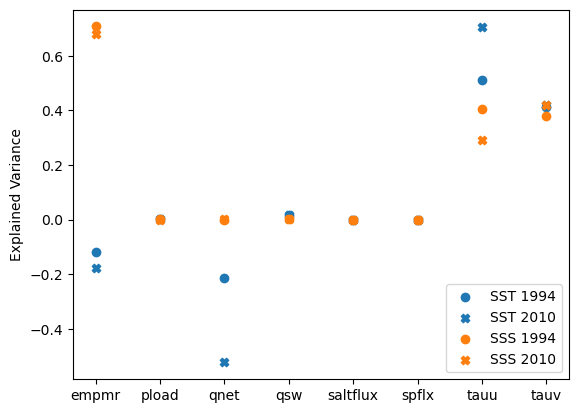

In [326]:
plot_ev_ctrl(ds_t_94_ev_ctrl, ds_t_10_ev_ctrl, ds_s_94_ev_ctrl, ds_s_10_ev_ctrl, "exp_variance.png")

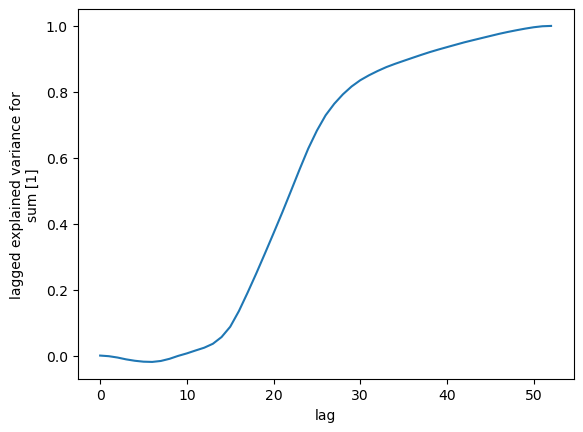

In [222]:
convolution.lagged_variance(ds_conv_t_94_anom, "sum").plot()